In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [2]:
gamma = 0.9
seed = 0
_render = True
log_interval = 10
num_actions = 3

torch.manual_seed(seed)

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'a_p', 'r', 's_'])

In [3]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(3, 100)
        self.a_head = nn.Linear(100, num_actions)

    def forward(self, x):
        x = F.relu(self.fc(x))
        action_score = self.a_head(x)
        return F.softmax(action_score, dim=-1)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(3, 100)
        self.a_head = nn.Linear(100, num_actions)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        state_value = self.v_head(x)
        return state_value

In [4]:
class Agent():

#     action_list = [(i * 4 - 2,) for i in range(num_actions)]
    action_list = [(-1,), (0,), (1,)]
    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 32

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()

        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-3)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-3)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.anet(state)
        m = Categorical(probs)
        action = m.sample()
        return self.action_list[action.item()], action.item(), probs[:, action].item()

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def save_param(self):
        torch.save(self.anet.state_dict(), 'param/ppo_d_anet_params.pkl')
        torch.save(self.cnet.state_dict(), 'param/ppo_d_cnet_params.pkl')

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.long).view(-1, 1)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)
        old_action_probs = torch.tensor([t.a_p for t in self.buffer], dtype=torch.float).view(-1, 1)

        r = (r - r.mean()) / (r.std() + 1e-5)

        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)
        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):
                action_probs = self.anet(s[index]).gather(1, a[index])
                ratio = action_probs / old_action_probs[index]

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [5]:
env = gym.make('Pendulum-v0')
env.seed(seed)

agent = Agent()

training_records = []
running_reward = -1000
state = env.reset()
for i_ep in range(1000):
    score = 0
    state = env.reset()

    for t in range(200):
        action, action_index, action_prob = agent.select_action(state)
        state_, reward, done, _ = env.step(action)
        if _render:
            env.render()
        if agent.store(Transition(state, action_index, action_prob, (reward + 8) / 8, state_)):
            agent.update()
        score += reward
        state = state_

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainingRecord(i_ep, running_reward))

    if i_ep % log_interval == 0:
        print('Ep {}\tMoving average score: {:.2f}\t'.format(i_ep, running_reward))
    if running_reward > -200:
        print("Solved! Moving average score is now {}!".format(running_reward))
        env.close()
        break

/home/ggrg/Documents/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


Ep 0	Moving average score: -1031.91	
Ep 10	Moving average score: -1291.35	
Ep 20	Moving average score: -1196.15	
Ep 30	Moving average score: -1310.45	
Ep 40	Moving average score: -1296.76	
Ep 50	Moving average score: -1103.07	
Ep 60	Moving average score: -989.77	
Ep 70	Moving average score: -933.11	
Ep 80	Moving average score: -884.12	
Ep 90	Moving average score: -845.20	
Ep 100	Moving average score: -928.75	
Ep 110	Moving average score: -961.87	
Ep 120	Moving average score: -826.20	
Ep 130	Moving average score: -759.74	
Ep 140	Moving average score: -783.60	
Ep 150	Moving average score: -693.86	
Ep 160	Moving average score: -609.33	
Ep 170	Moving average score: -683.82	
Ep 180	Moving average score: -623.55	
Ep 190	Moving average score: -479.23	
Ep 200	Moving average score: -521.53	
Ep 210	Moving average score: -393.22	
Ep 220	Moving average score: -411.41	
Ep 230	Moving average score: -529.12	
Ep 240	Moving average score: -500.19	
Ep 250	Moving average score: -504.91	
Ep 260	Moving ave

KeyboardInterrupt: 

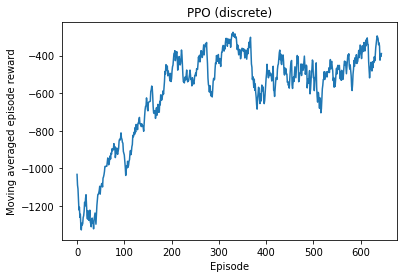

In [7]:
plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO (discrete)')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()